En "Branching process- etiquetar" se construye un arbol con modelo de branching process, se etiqueta usando una cadena de markov, y se observa que la proporcion de etiquetas en las hojas del arbol y la proporcion de etiquetas en todos los nodos del arbol se acercan demasiado a la distribucion limite de la cadena de markov.

La idea es observar si esto se mantiene para un arbol generado con modelo de barabasi. Es decir, se hace lo siguiente:

1) Se genera un arbol con modelo de barabasi

2) Se etiqueta usando una cadena de markov

3) Se calculan las siguientes distribuciones:

3.1) Distribucion limite de la cadena de markov

3.2) Proporcion de las etiquetas en las hojas

3.3) Proporcion de las etiquetas en todos los nodos

4) Se comparan estas distribuciones para ver si son parecidas.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import scipy

Funciones para dibujar el arbol

In [2]:
def hierarchy_pos(G, root=None, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5):
    pos = _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)
    return pos

In [3]:
def _hierarchy_pos(G, root, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5, pos=None, parent=None, parsed=[]):
    if pos is None:
        pos = {root: (xcenter, vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    children = list(G.neighbors(root))
    if not isinstance(G, nx.DiGraph) and parent is not None:
        children.remove(parent)  
          
    if len(children) != 0:
        dx = width / 2 
        nextx = xcenter - width/2 - dx/2
        for child in children:
            nextx += dx
            pos = _hierarchy_pos(G, child, width=dx, vert_gap=vert_gap, vert_loc=vert_loc-vert_gap, xcenter=nextx, pos=pos, parent=root, parsed=parsed)
    return pos

In [4]:
def draw_tree(tree, root=0, colores = False):
    
    # si colores == True, significa que el arbol tiene colores asignados
    # como node atributes, con la llave de 'color'
    if colores:
        # tomar los atributos de los colores
        colores_nodos = [tree.nodes[nodo]['color'] for nodo in tree.nodes()]
    # sino tienen atributos de colores, ponerlos a todos del mismo color
    else:
        colores_nodos = "skyblue"
        
    # dibujar el arbol
    pos = hierarchy_pos(tree, root) 
    nx.draw(tree, pos, with_labels=True, node_size=700, node_color=colores_nodos, font_size=8, font_color="black", font_weight="bold", edge_color="gray", linewidths=1, alpha=0.7)
    plt.show()

## Generacion del arbol

## Barabasi

In [5]:
from networkx import barabasi_albert_graph

In [6]:
def convertir_a_arbol_dirigido(grafo_no_dirigido, nodo_raiz):
    
    # Encuentra la distancia de cada nodo al nodo raíz
    distancias = nx.single_source_shortest_path_length(grafo_no_dirigido, nodo_raiz)

    # Inicializa un grafo dirigido
    grafo_dirigido = nx.DiGraph()

    # Añade nodos al grafo dirigido
    grafo_dirigido.add_nodes_from(grafo_no_dirigido.nodes())

    # Añade aristas al grafo dirigido con dirección de nodo más cercano al nodo raíz a más lejano
    for nodo_destino, distancia in distancias.items():
        if nodo_destino != nodo_raiz:
            # Encuentra el nodo anterior en el camino hacia el nodo raíz
            nodo_anterior = min(grafo_no_dirigido.neighbors(nodo_destino), key=lambda x: distancias[x])

            # Añade una arista dirigida desde el nodo anterior al nodo destino
            grafo_dirigido.add_edge(nodo_anterior, nodo_destino)

    return grafo_dirigido

Asumo que el nodo raiz del arbol generado es aquel con etiqueta 0

In [7]:
def arbol_barabasi(num_nodos):
    
    # usar las funciones para generar un arbol con barabasi
    arbol_no_dirigido = barabasi_albert_graph(num_nodos, 1)
    
    # hacerlo dirigido, la raiz es el 0
    arbol_dirigido = convertir_a_arbol_dirigido(arbol_no_dirigido, 0)
    
    # comprobar que sea un DAG
    assert nx.is_directed_acyclic_graph(arbol_dirigido)
    
    return arbol_dirigido

## Definir la cadena de markov de las etiquetas

Se define una cadena de markov, donde los estados son colores.

In [8]:
def generate_random_transition_matrix(states):
    
    num_states = len(states)

    # Generate a random matrix with values between 0 and 1
    random_matrix = np.random.rand(num_states, num_states)

    # Normalize the matrix so that each row sums to 1
    transition_matrix = random_matrix / random_matrix.sum(axis=1, keepdims=True)

    return transition_matrix

In [9]:
def visualize_markov_chain(states, transition_matrix):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes to the graph without labels
    for state in states:
        G.add_node(state, color=state)

    # Add edges with weights proportional to conditional probabilities
    for i in range(len(states)):
        for j in range(len(states)):
            weight = transition_matrix[i, j]
            if weight > 0:
                G.add_edge(states[i], states[j], weight=weight)
                
    # Extract node colors from the graph
    node_colors = [node[1]['color'] for node in G.nodes(data=True)]

    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=False, node_size=1000, node_color=node_colors, font_size=10, font_color='white',
            font_weight='bold', edge_color='black', width=[edge[2]['weight'] * 10 for edge in G.edges(data=True)],
            arrowsize=20, connectionstyle='arc3,rad=0.1')  # Modified to draw edges between all pairs

    # Display the plot
    plt.show()

## Etiquetar el arbol

Para etiquetar los nodos se va usar la cadena de markov, el color de un nodo solo depende del nodo de su predecesor.

Para asignar las etiquetas a los nodos, se usan los atributos de los nodos, que son diccionarios.

In [10]:
# ponerle una etiqueta a un nodo en un grafo
def etiquetar(nodo, indice_etiqueta, grafo):
    
    # poner la etiqueta como parte del diccionario
    # asociado a cada nodo
    # con la llave de etiqueta
    grafo.nodes[nodo]['etiqueta'] = indice_etiqueta

In [11]:
# dado un nodo de un grafo, obtener su etiqueta
def get_etiqueta(nodo, grafo):
    
    # devuelve la etiqueta de un nodo
    return grafo.nodes[nodo]['etiqueta']

In [12]:
# funcion usada para escojer un indice de acuerdo a las probabilidades
def elegir_indice_con_probabilidades(probabilidades):
    
    indices = list(range(len(probabilidades)))
    
    indice_elegido = random.choices(indices, weights=probabilidades, k=1)[0]
    
    return indice_elegido

In [13]:
def etiquetar_arbol(arbol, nodo_raiz, indice_etiqueta_raiz, transition_matrix):
    
    # tomar los nods del arbol
    nodos = list(arbol.nodes)
    
    # poner una etiqueta por nodo
    # de momento todos inician en -1
    for nodo in nodos:
        etiquetar(nodo, -1, arbol)
    
    # la etiqueta de la raiz se define antes de empezar

    # iterar en los nodos del grafo para etiquetar
    # iterar usando bfs

    visitados = set()
    cola = [nodo_raiz]

    # iterar mientras haya elementos en la cola
    while cola:
        # sacar el primero de la cola (bfs)
        nodo_actual = cola.pop(0)

        # si no se ha visto
        if nodo_actual not in visitados:

            # se etiqueta el nodo

            # si es la raiz, ya se definio la etiquera
            if nodo_actual == nodo_raiz:
                etiquetar(nodo_actual, indice_etiqueta_raiz, arbol)

            # no es la raiz,
            # definir la etiqueta con base a la etiqeuta del padre
            else:

                # tomar los padres
                padres_ = arbol.predecessors(nodo_actual)
                padres = [p for p in padres_]

                # comprobar que sesa solo 1, y tomarlo
                assert len(padres) == 1

                padre = padres[0]

                # tomar el indice de la etiqueta del padre
                indice_etiqueta_padre = get_etiqueta(padre, arbol)

                # comprobar que ya tenga etiqueta
                assert indice_etiqueta_padre != -1

                # tomas las probabilidades
                proba_etiquetas = transition_matrix[indice_etiqueta_padre]

                # hacer un sampleo, segun estas probabilidades
                # para seleccionar el indice de esta etiqueta
                indice_etiqueta_actual = elegir_indice_con_probabilidades(proba_etiquetas)

                # etiquetar
                etiquetar(nodo_actual, indice_etiqueta_actual, arbol)


            # como sea, se marca como visitado
            visitados.add(nodo_actual)

            # se añadren los siguientes nodos
            vecinos = list(arbol.successors(nodo_actual))
            cola.extend(vecinos)
            
    # se tienen los indices de las etiquetas
    # ademas, se quieren los colores asociados
    
    # convertirlas en colores
    # tambien ponerle colores al grafo
    for nodo in nodos:
        arbol.nodes[nodo]['color'] = etiquetas[get_etiqueta(nodo, arbol)]

### Hacer todo

Primero con uno pequeño, a ver si funciona

In [14]:
# estados de la cadena de markov
etiquetas = ['red', 'blue', 'green', 'orange', 'pink', 'purple', 'aquamarine', 'mediumseagreen']
# etiquetas = np.linspace(start = 0, stop = 1, num = 63)

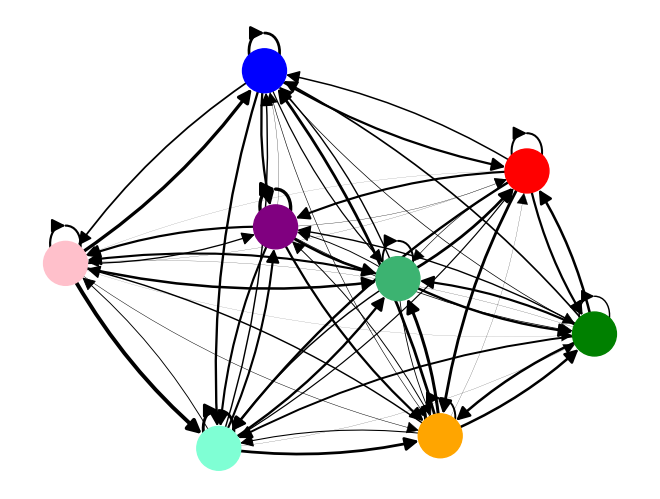

In [15]:
# definir la matriz de transicion de la cadena de markov
transition_matrix = generate_random_transition_matrix(etiquetas)


# ver las probabilidades
visualize_markov_chain(etiquetas, transition_matrix)

In [16]:
transition_matrix

array([[0.14625492, 0.10888165, 0.16225162, 0.20259019, 0.00779622,
        0.15564823, 0.1738211 , 0.04275608],
       [0.16242664, 0.19571588, 0.0510132 , 0.04189608, 0.1261596 ,
        0.16621177, 0.16769389, 0.08888296],
       [0.18358938, 0.12020858, 0.10284417, 0.18140371, 0.0127428 ,
        0.10007384, 0.1412248 , 0.15791271],
       [0.01328055, 0.20049156, 0.18145012, 0.13820143, 0.10418228,
        0.06907277, 0.07732976, 0.21599154],
       [0.01190052, 0.23477033, 0.00773403, 0.03456524, 0.15533989,
        0.09311935, 0.28107397, 0.18149667],
       [0.02262835, 0.01871527, 0.05244075, 0.16178888, 0.15837448,
        0.24106495, 0.15588583, 0.18910149],
       [0.08465736, 0.10352577, 0.01107365, 0.19828422, 0.06700785,
        0.15409318, 0.21039321, 0.17096475],
       [0.19663107, 0.09960575, 0.1749543 , 0.06114731, 0.15346082,
        0.06900343, 0.1029509 , 0.14224641]])

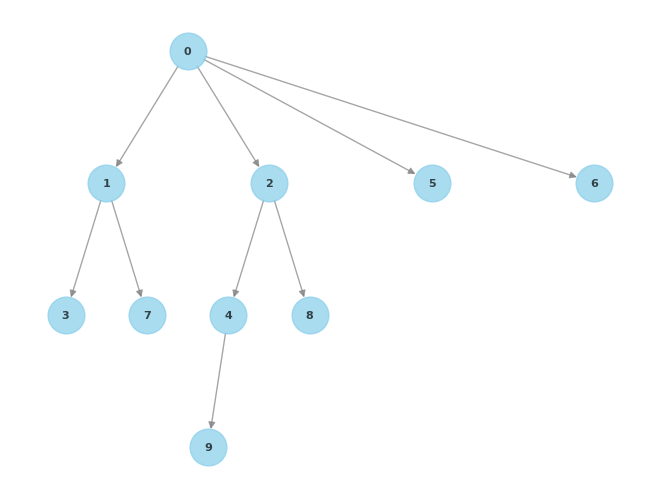

In [17]:
# hacer un arbol pequeño para ver si funciona
grafo = arbol_barabasi(num_nodos = 10)

# ver 
draw_tree(grafo, root = 0)

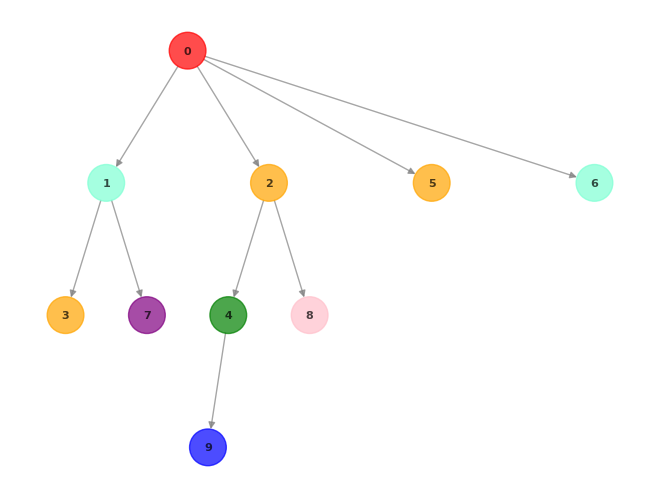

In [18]:
# etiquetar
etiquetar_arbol(grafo, nodo_raiz = 0, indice_etiqueta_raiz = 0, transition_matrix = transition_matrix)

# verlo con etiquetas
draw_tree(grafo, root = 0, colores = True)

Hacerlo con un arbol mas grande

Comprobar si la dsitribucion de las hojas sigue la distribucion limite de la cadena

In [19]:
num_nodos = 120000

# hacer el arbol grande
grafo = arbol_barabasi(num_nodos = num_nodos)

# etiquetar
etiquetar_arbol(grafo, nodo_raiz = 0, indice_etiqueta_raiz = 0, transition_matrix = transition_matrix)

In [20]:
print(f"Se tienen {grafo.number_of_nodes()} nodos")
print(f"Se tienen {grafo.number_of_edges()} edges")

Se tienen 120000 nodos
Se tienen 119999 edges


## Distribucion de las hojas

In [21]:
# tomar las hojas
hojas = [node for node in grafo.nodes() if grafo.out_degree(node) == 0]
print(f"Se tienen {len(hojas)} hojas")


# obtener las etiquetas de las hojas
etiquetas_hojas = np.array([get_etiqueta(hoja, grafo) for hoja in hojas])

Se tienen 80013 hojas


In [22]:
# obtener las proporciones de las etiquetas en las hojas

proporciones_hojas = [-1] * len(etiquetas)

# tal que 
# proporciones_hojas[0] = proporcion de hojas con etiqueta con indice 0

for idx_etiqueta in range(len(etiquetas)):
    
    # obtener el numero de hojas con este indice de etiqeuta
    num_hojas = sum([1 for etiqueta_hoja in etiquetas_hojas
                    if etiqueta_hoja == idx_etiqueta])
    
    # añadir la proporcion
    # el numero de hojas con ese etiqeuta 
    # sobre el numero total del hojas
    proporciones_hojas[idx_etiqueta] = num_hojas/len(hojas)
    
print("Las proporciones de las hojas son: ")
print(proporciones_hojas)

print("\nEs decir:")
for idx, proporcion in enumerate(proporciones_hojas):
    print(f"Se tiene {round(proporcion, 3)} para la etiqueta {etiquetas[idx]}")

Las proporciones de las hojas son: 
[0.10340819616812268, 0.13386574681614238, 0.09257245697574144, 0.12712934148200916, 0.10228337895092048, 0.129591441390774, 0.16069888643095498, 0.1504505517853349]

Es decir:
Se tiene 0.103 para la etiqueta red
Se tiene 0.134 para la etiqueta blue
Se tiene 0.093 para la etiqueta green
Se tiene 0.127 para la etiqueta orange
Se tiene 0.102 para la etiqueta pink
Se tiene 0.13 para la etiqueta purple
Se tiene 0.161 para la etiqueta aquamarine
Se tiene 0.15 para la etiqueta mediumseagreen


## Distribucion de limite

In [23]:
# comprueba que una matriz es una matriz de probabilidad
# i.e que las filas suman a 1, y no tiene entradas negativas
def comprobar_matriz_probabilidad(matriz):
    
    # verificar si todas las entradas son no negativas
    if np.any(matriz < 0):
        return False
    
    # verificar si la suma de cada fila es aproximadamente igual a 1
    filas_suman_a_1 = np.all(np.isclose(np.sum(matriz, axis=1), 1))
    
    return filas_suman_a_1

In [24]:
def get_distribucion_limite(matriz_transicion):
    '''
    Toma la matriz de transicion de una cadena de markov
    Devuelve la distribucion limite de la cadena de markov
    
    Lo que se hace es checar si es irreducible y aperiodica.
    Pues si la cadena de markov es irreducible, aperiodica.
    Entonces la distribucion limite es la distribucion estacionaria.
    '''
    
    # comprobar que si sea de probabilidad
    assert comprobar_matriz_probabilidad(matriz_transicion)
    
    # Crear un grafo dirigido desde la matriz de transición
    grafo_markov = nx.DiGraph(matriz_transicion)
    
    # ver si es irreducible
    irreducible = nx.is_strongly_connected(grafo_markov)

    if irreducible:
        print("La cadena es irreducible")
    else:
        print("La cadena no es irreducible")
        return None
    
    # ver si es aperiodica
    is_aperiodic = nx.is_aperiodic(grafo_markov)

    if irreducible:
        print("La cadena es aperiodica")
    else:
        print("La cadena no es aperiodica")
        return None
    
    # Calcular la dsitribucion estacionaria
    
    # eigenvalores y eigenvectores
    eigenvalores, eigenvectores = np.linalg.eig(matriz_transicion.T)

    # tomar el eigenvector asociado al eigenvalor 1
    eigenvector_1 = np.real_if_close(eigenvectores[:, np.isclose(eigenvalores, 1)])

    # reshape
    eigenvector_1 = eigenvector_1.reshape(-1)

    # si suma uno es la distribucion estacionaria
    distribucion_estacionaria = eigenvector_1 / np.sum(eigenvector_1)
    
    # devolverla
    return list(distribucion_estacionaria)

In [25]:
distribucion_limite = get_distribucion_limite(transition_matrix)
distribucion_limite

La cadena es irreducible
La cadena es aperiodica


[0.10241010343865596,
 0.1316646997749877,
 0.09164184227873994,
 0.12666278880950266,
 0.10267851665714177,
 0.13257590042300252,
 0.1616731855558103,
 0.15069296306215918]

Comprobar que sea la limite (multiplicandola muchas veces)

In [26]:
np.linalg.matrix_power(transition_matrix, 100)

array([[0.1024101 , 0.1316647 , 0.09164184, 0.12666279, 0.10267852,
        0.1325759 , 0.16167319, 0.15069296],
       [0.1024101 , 0.1316647 , 0.09164184, 0.12666279, 0.10267852,
        0.1325759 , 0.16167319, 0.15069296],
       [0.1024101 , 0.1316647 , 0.09164184, 0.12666279, 0.10267852,
        0.1325759 , 0.16167319, 0.15069296],
       [0.1024101 , 0.1316647 , 0.09164184, 0.12666279, 0.10267852,
        0.1325759 , 0.16167319, 0.15069296],
       [0.1024101 , 0.1316647 , 0.09164184, 0.12666279, 0.10267852,
        0.1325759 , 0.16167319, 0.15069296],
       [0.1024101 , 0.1316647 , 0.09164184, 0.12666279, 0.10267852,
        0.1325759 , 0.16167319, 0.15069296],
       [0.1024101 , 0.1316647 , 0.09164184, 0.12666279, 0.10267852,
        0.1325759 , 0.16167319, 0.15069296],
       [0.1024101 , 0.1316647 , 0.09164184, 0.12666279, 0.10267852,
        0.1325759 , 0.16167319, 0.15069296]])

In [27]:
print("Las distribucion limite en: ")
print(distribucion_limite)

print("\nEs decir:")
for idx, probabilidad in enumerate(distribucion_limite):
    print(f"Se tiene {round(probabilidad, 3)} para la etiqueta {etiquetas[idx]}")

Las distribucion limite en: 
[0.10241010343865596, 0.1316646997749877, 0.09164184227873994, 0.12666278880950266, 0.10267851665714177, 0.13257590042300252, 0.1616731855558103, 0.15069296306215918]

Es decir:
Se tiene 0.102 para la etiqueta red
Se tiene 0.132 para la etiqueta blue
Se tiene 0.092 para la etiqueta green
Se tiene 0.127 para la etiqueta orange
Se tiene 0.103 para la etiqueta pink
Se tiene 0.133 para la etiqueta purple
Se tiene 0.162 para la etiqueta aquamarine
Se tiene 0.151 para la etiqueta mediumseagreen


## Distribucion de todos los nodos

In [28]:
# se tienen las etiquetas de todo el arbol

# tomar los nodos
nodos = grafo.nodes()

# obtener las etiquetas de todos los nodos
etiquetas_full = np.array([get_etiqueta(node, grafo) for node in nodos])


print(f"Se tienen {len(etiquetas_full)} nodos en todo el arbol")
print("Checar la distribucion")

Se tienen 120000 nodos en todo el arbol
Checar la distribucion


In [29]:
# obtener las proporciones de las etiquetas en todo el arbol

proporciones_arbol = [-1] * len(etiquetas)

# tal que 
# proporciones_arbol[0] = proporcion de nodos en todo el arbol con etiqueta con indice 0


for idx_etiqueta in range(len(etiquetas)):
    
    # obtener el numero de nodos con este indice de etiqeuta
    num_nodos = sum([1 for etiqueta_nodo in etiquetas_full
                    if etiqueta_nodo == idx_etiqueta])
    
    # añadir la proporcion
    # el numero de nodos con ese etiqeuta 
    # sobre el numero total del nodos
    proporciones_arbol[idx_etiqueta] = num_nodos/len(etiquetas_full)
    
print("Las proporciones de los nodos en el arbol son: ")
print(proporciones_arbol)

print("\nEs decir:")
for idx, proporcion in enumerate(proporciones_arbol):
    print(f"Se tiene {round(proporcion, 3)} para la etiqueta {etiquetas[idx]}")

Las proporciones de los nodos en el arbol son: 
[0.102275, 0.13415833333333332, 0.09306666666666667, 0.127025, 0.10315, 0.12965833333333332, 0.16025833333333334, 0.15040833333333334]

Es decir:
Se tiene 0.102 para la etiqueta red
Se tiene 0.134 para la etiqueta blue
Se tiene 0.093 para la etiqueta green
Se tiene 0.127 para la etiqueta orange
Se tiene 0.103 para la etiqueta pink
Se tiene 0.13 para la etiqueta purple
Se tiene 0.16 para la etiqueta aquamarine
Se tiene 0.15 para la etiqueta mediumseagreen


## Comparar las 3 distribuciones

Distribucion limite

Distribucion de las hojas

Distribucion de todos los nodos

In [30]:
print("Las proporciones de las hojas son: ")
print(proporciones_hojas)

print("\nEs decir:")
for idx, proporcion in enumerate(proporciones_hojas):
    print(f"Se tiene {round(proporcion, 3)} para la etiqueta {etiquetas[idx]}")
    
print("-"*100)

print("Las distribucion limite es: ")
print(distribucion_limite)

print("\nEs decir:")
for idx, probabilidad in enumerate(distribucion_limite):
    print(f"Se tiene {round(probabilidad, 3)} para la etiqueta {etiquetas[idx]}")
    
print("-"*100)

print("Las proporciones de los nodos en el arbol son: ")
print(proporciones_arbol)

print("\nEs decir:")
for idx, proporcion in enumerate(proporciones_arbol):
    print(f"Se tiene {round(proporcion, 3)} para la etiqueta {etiquetas[idx]}")

Las proporciones de las hojas son: 
[0.10340819616812268, 0.13386574681614238, 0.09257245697574144, 0.12712934148200916, 0.10228337895092048, 0.129591441390774, 0.16069888643095498, 0.1504505517853349]

Es decir:
Se tiene 0.103 para la etiqueta red
Se tiene 0.134 para la etiqueta blue
Se tiene 0.093 para la etiqueta green
Se tiene 0.127 para la etiqueta orange
Se tiene 0.102 para la etiqueta pink
Se tiene 0.13 para la etiqueta purple
Se tiene 0.161 para la etiqueta aquamarine
Se tiene 0.15 para la etiqueta mediumseagreen
----------------------------------------------------------------------------------------------------
Las distribucion limite es: 
[0.10241010343865596, 0.1316646997749877, 0.09164184227873994, 0.12666278880950266, 0.10267851665714177, 0.13257590042300252, 0.1616731855558103, 0.15069296306215918]

Es decir:
Se tiene 0.102 para la etiqueta red
Se tiene 0.132 para la etiqueta blue
Se tiene 0.092 para la etiqueta green
Se tiene 0.127 para la etiqueta orange
Se tiene 0.103 

In [31]:
# poner las distribuciones a comparar
distribuciones = [np.array(distribucion_limite), np.array(proporciones_hojas), np.array(proporciones_arbol)]

# poner los nombres
nombres_distribuciones = ["Distribucion limite", "Distribucion de las hojas", "Distribucion de todos los nodos"]

In [32]:
def plot_distribution(distribucion, ax):
    # toma una ditribucion sobre las etiquetas
    # la grafica
    
    # ver que tenga los mismos elementos
    assert len(etiquetas)==len(distribucion)
    
    # hacer las barras
    ax.bar(etiquetas, distribucion)
    
    # poner los valores
    for i, valor in enumerate(distribucion):
        ax.text(i, valor, f'{valor:.3f}', ha='center', va='bottom')
        
    # devolevr el ax
    return ax

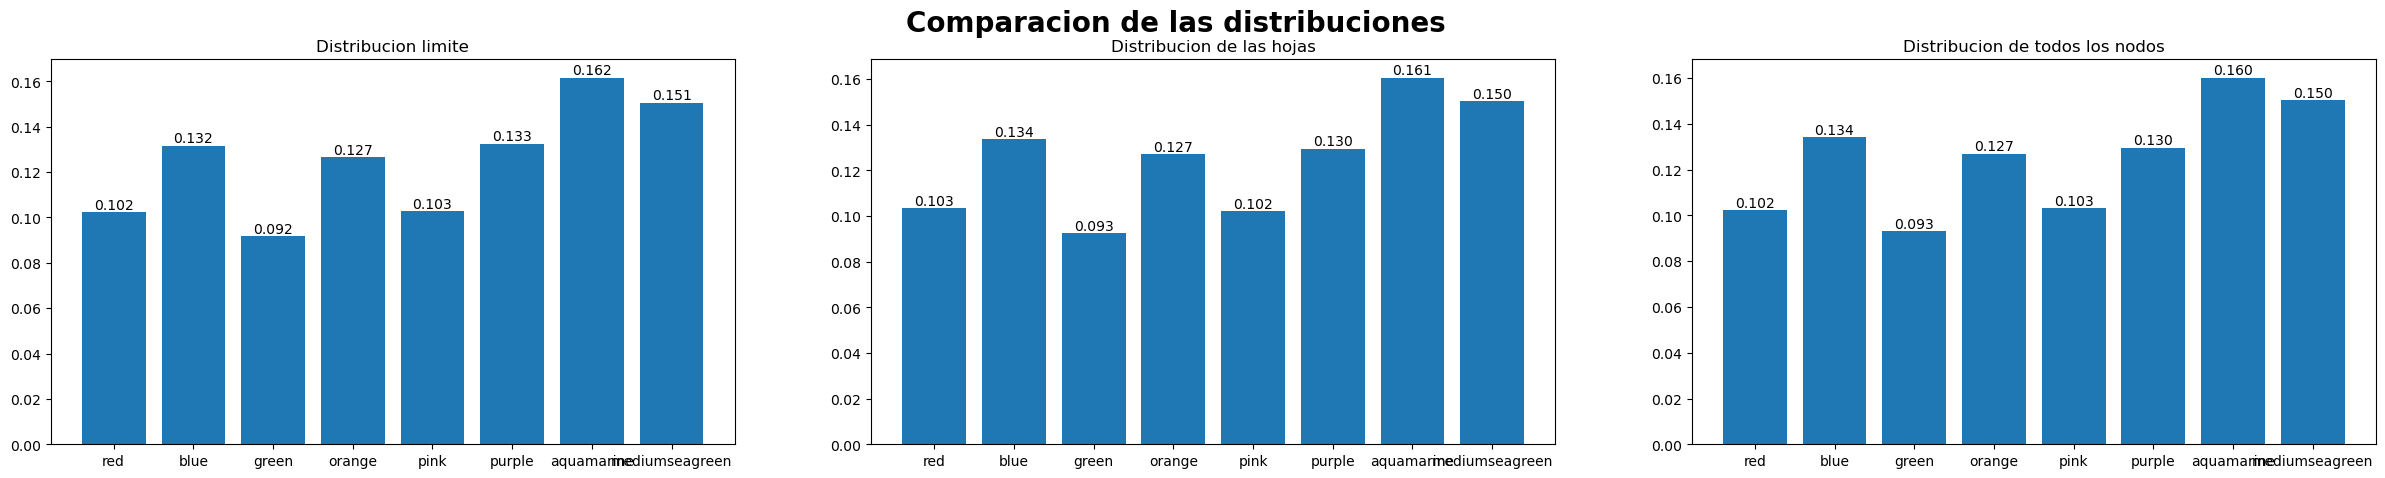

In [33]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))

# distribucion limite
plot_distribution(distribuciones[0], ax[0])
ax[0].set_title(nombres_distribuciones[0])

# distribucion de las hojas
plot_distribution(distribuciones[1], ax[1])
ax[1].set_title(nombres_distribuciones[1])

# distribucion de todos los nodos
plot_distribution(distribuciones[2], ax[2])
ax[2].set_title(nombres_distribuciones[2])

# mostrar
fig.suptitle("Comparacion de las distribuciones", fontsize=20, fontweight='bold')
plt.show()

In [34]:
# funcion para calcular la KL divergence D(p|q)
# no es una metrica, no es simetrica ni lo del triangulo, es una divergencia
def KL_divergence(p, q):
    return scipy.stats.entropy(p, q)

In [35]:
# calcular la kl_divergence de todos los pares posibles
kl_matrix = np.zeros((3, 3))

# iterar en los pares
for i in range(3):
    for j in range(3):
        # calccular la divergencia del par correspondiente
        kl_matrix[i, j] = KL_divergence(distribuciones[i], distribuciones[j])

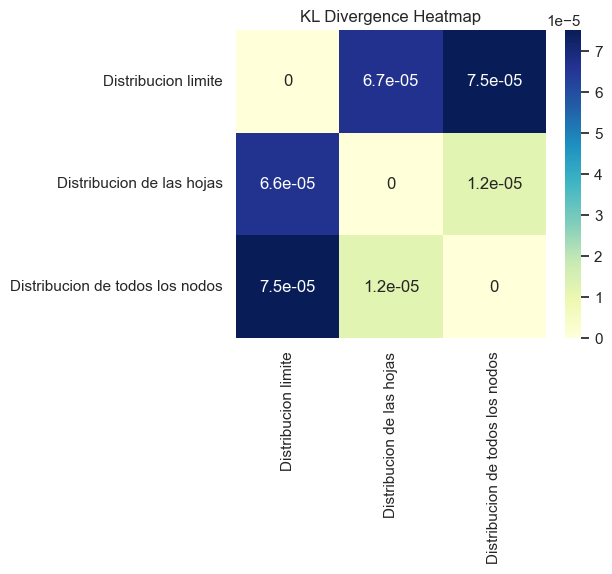

In [36]:
# Hacer un heatmap con esta informacion
sns.set()
plt.figure(figsize=(5, 4))
sns.heatmap(kl_matrix, annot=True, cmap="YlGnBu", 
            xticklabels=nombres_distribuciones, yticklabels=nombres_distribuciones)
plt.title("KL Divergence Heatmap")
plt.show()

## Estimar la matriz de transicion

In [37]:
# comprueba que una matriz es una matriz de probabilidad
# i.e que las filas suman a 1, y no tiene entradas negativas
def comprobar_matriz_probabilidad(matriz):
    
    # verificar si todas las entradas son no negativas
    if np.any(matriz < 0):
        return False
    
    # verificar si la suma de cada fila es aproximadamente igual a 1
    filas_suman_a_1 = np.all(np.isclose(np.sum(matriz, axis=1), 1))
    
    return filas_suman_a_1

In [38]:
def estimar_markov(grafo, num_etiquetas):
    '''
    Toma un grafo etiquetado
    Es decir, donde cada nodo tiene un atributo con nombre 'etiqueta'
    Las etiquetas son numeros en {0, 1, ..., num_etiquetas-1}
    Se asume que el etiquetado del grafo sigue un proceso de cadena de markov
    Se busca estimar la matriz de transicion de esta
    Se devuelve la estimacion de esta matriz de transicion
    '''

    # hacer una matriz que cuente de donde a donde van las aristas
    # inicializar la matriz con ceros
    matriz_contar = np.zeros((num_etiquetas, num_etiquetas))

    # iterar en las aristas
    for edge in grafo.edges():

        # tomar al padre, y su etiqueta
        padre = edge[0]
        etiqueta_padre = get_etiqueta(padre, grafo)

        # tomar al hijo, y su etiqueta
        hijo = edge[1]
        etiqueta_hijo = get_etiqueta(hijo, grafo)


        # sumar en uno la cuenta 
        # de las aristas que vienen de la etiqueta del padre
        # a la etiqueta del hijo
        matriz_contar[etiqueta_padre, etiqueta_hijo] = matriz_contar[etiqueta_padre, etiqueta_hijo] + 1

    # comprobar que se hayan contado todas las aristas del grafo
    assert grafo.number_of_edges() == matriz_contar.sum()

    # si una fila se llena de ceros
    # entonces no se tiene info de la proba condicional
    # se llena con unos, para que sea uniforme
    for fila in range(matriz_contar.shape[0]):
            if np.all(matriz_contar[fila, :] == 0):
                print(f"No se tenia informacion hijos cuyo padre tiene etiqueta: {fila}")
                print("La informacion condicional dada esa etiqueta se hace uniforme")
                matriz_contar[fila, :] = 1


    # para estimar las probabilidades condicionales
    # se normaliza cada fila para que sume uno
    matriz_estimada = matriz_contar / matriz_contar.sum(axis=1)[:, np.newaxis]

    # comprobar que sea matriz de probabilidad
    assert comprobar_matriz_probabilidad(matriz_estimada)

    # devolver la estimacion
    return matriz_estimada

In [39]:
# hacer la estimacion
matriz_markov_estimada = estimar_markov(grafo, len(etiquetas))

# obtener la limite de la estimacion
distribucion_limite_estimada = get_distribucion_limite(matriz_markov_estimada)

La cadena es irreducible
La cadena es aperiodica


### Comparar esta con las otras 3 distribuciones

In [40]:
# pones las distribuciones a comparar
distribuciones = [np.array(distribucion_limite), np.array(distribucion_limite_estimada), 
                  np.array(proporciones_hojas), np.array(proporciones_arbol)]

# poner los nombres
nombres_distribuciones = ["Distribucion limite", "Distribucion limite estimada", 
                          "Distribucion de las hojas", "Distribucion de todos los nodos"]

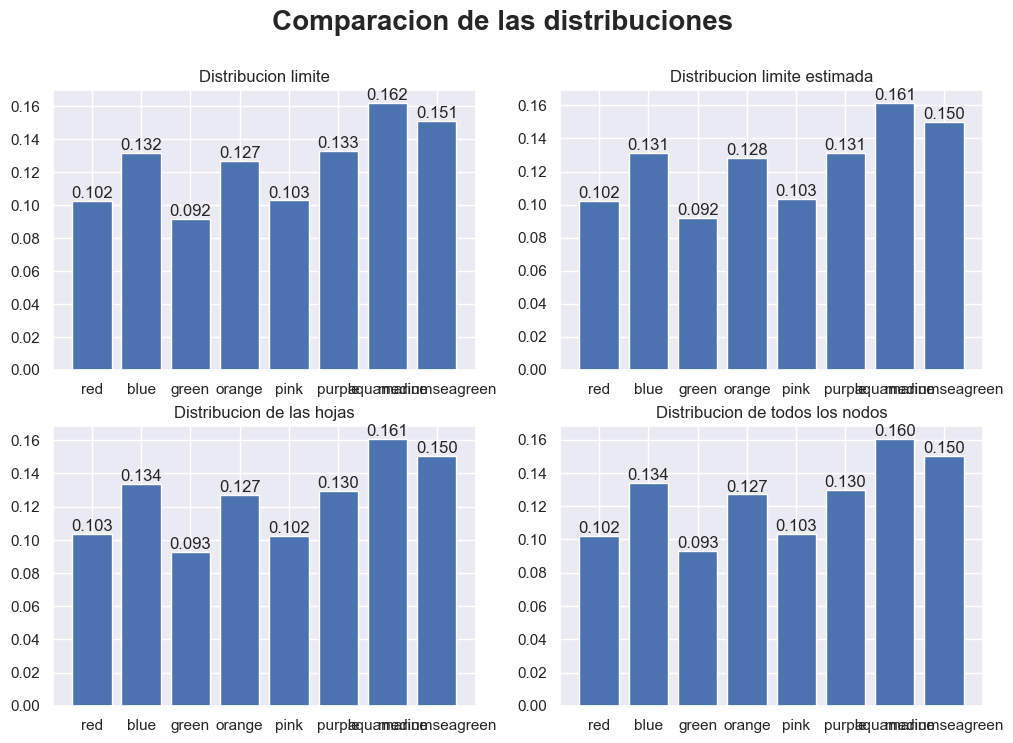

In [41]:
fig, ax = plt.subplots(2, 2, figsize = (12, 8))

# distribucion limite
plot_distribution(distribuciones[0], ax[0, 0])
ax[0, 0].set_title(nombres_distribuciones[0])

# distribucion limite estimada
plot_distribution(distribuciones[1], ax[0, 1])
ax[0, 1].set_title(nombres_distribuciones[1])

# distribucion de las hojas
plot_distribution(distribuciones[2], ax[1, 0])
ax[1, 0].set_title(nombres_distribuciones[2])

# distribucion de todos los nodos
plot_distribution(distribuciones[3], ax[1, 1])
ax[1, 1].set_title(nombres_distribuciones[3])

# mostrar
fig.suptitle("Comparacion de las distribuciones", fontsize=20, fontweight='bold')
plt.show()

In [42]:
# calcular la kl_divergence de todos los pares posibles
kl_matrix = np.zeros((4, 4))

# iterar en los pares
for i in range(4):
    for j in range(4):
        # calccular la divergencia del par correspondiente
        kl_matrix[i, j] = KL_divergence(distribuciones[i], distribuciones[j])

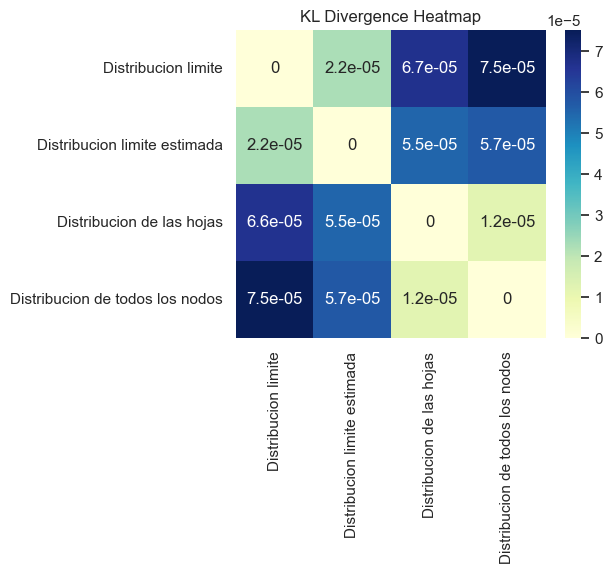

In [43]:
# Hacer un heatmap con esta informacion
sns.set()
plt.figure(figsize=(5, 4))
sns.heatmap(kl_matrix, annot=True, cmap="YlGnBu", 
            xticklabels=nombres_distribuciones, yticklabels=nombres_distribuciones)
plt.title("KL Divergence Heatmap")
plt.show()